<a href="https://colab.research.google.com/github/tywong/tensorflow-learning/blob/master/TensorFlow_Tutorial_Boosted_Trees_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TensorFlow Tutorial - Boosted Trees models

## Install Packages

In [1]:
!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf
tf.random.set_seed(123)

    100% |████████████████████████████████| 79.9MB 405kB/s 
    100% |████████████████████████████████| 61kB 20.7MB/s 
    100% |████████████████████████████████| 419kB 15.7MB/s 
    100% |████████████████████████████████| 3.0MB 11.0MB/s 


## Load the dataset - Titanic dataset

In [0]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
from IPython.display import clear_output

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')


In [3]:
dftrain.keys()

Index(['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare',
       'class', 'deck', 'embark_town', 'alone'],
      dtype='object')

In [4]:
dftrain.head(3)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y


In [5]:
dfeval.keys()

Index(['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare',
       'class', 'deck', 'embark_town', 'alone'],
      dtype='object')

In [0]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## Explorary Data Analysis

In [7]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [8]:
dftrain.shape

(627, 9)

### Histograms

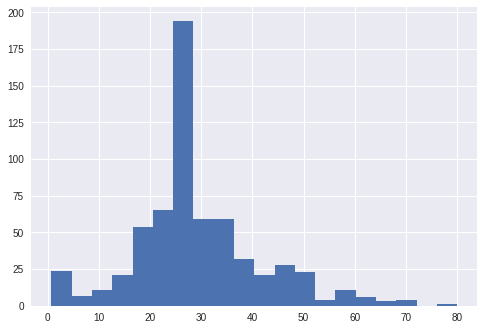

In [9]:
dftrain.age.hist(bins=20);

male      410
female    217
Name: sex, dtype: int64


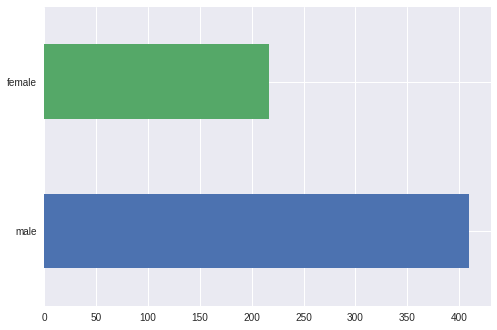

In [10]:
output = dftrain.sex.value_counts()
print(output)
output.plot(kind='barh');

Third     341
First     159
Second    127
Name: class, dtype: int64


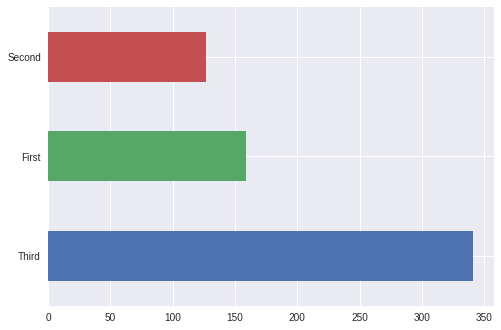

In [11]:
output = dftrain['class'].value_counts()
print(output)
output.plot(kind='barh');

Southampton    450
Cherbourg      123
Queenstown      53
unknown          1
Name: embark_town, dtype: int64


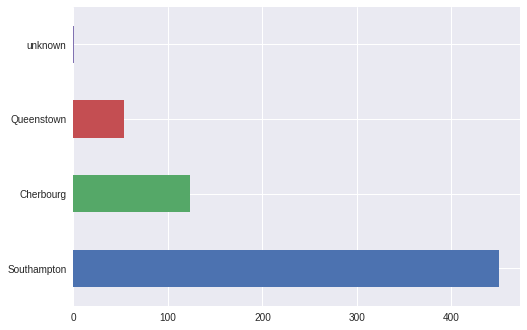

In [12]:
output = dftrain['embark_town'].value_counts();
print(dftrain['embark_town'].value_counts())
dftrain['embark_town'].value_counts().plot(kind='barh');

sex
female    0.778802
male      0.180488
Name: survived, dtype: float64


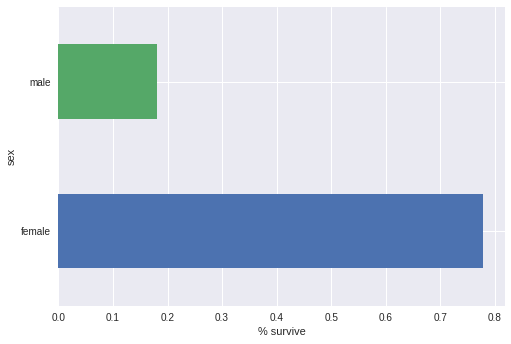

In [13]:
output = pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean()
print(output)
output.plot(kind='barh').set_xlabel('% survive');

In [14]:
gb = pd.concat([dftrain, y_train], axis=1).groupby('sex').survived
print(gb.value_counts())

sex     survived
female  1           169
        0            48
male    0           336
        1            74
Name: survived, dtype: int64


## Create Feature Columns

Create columns definitions using `tf.feature_column`


Reference: https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list

In [0]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
  
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

In [0]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

In [20]:
for x in feature_columns: print(x)

IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0))
IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0))
IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0))
IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0))
IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0))
IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary

### Inspect all feature columns using `DenseFeature`

- `DenseFeature` is for producing a tensor based on the input feature columns.

Reference: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/DenseFeatures

In [25]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

### Example

In [23]:
example = dict(dftrain.head(1))

class_fc = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        'class', ('First', 'Second', 'Third')
    )
)

print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


## Adding data using `Dataset.from_tensor_slices`

In [27]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)
NUM_EXAMPLES

627

In [0]:
def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

In [0]:
# Training input functions.
train_input_fn = make_input_fn(dftrain, y_train)

# Evaluation input functions.
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

## Train and evaluate model

Reference: https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier

### Without Boosting

In [34]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

W0326 00:49:26.282208 139729640953728 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpnpo43ho4


In [0]:
# Evaluation.
result = linear_est.evaluate(eval_input_fn)

In [36]:
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
global_step             100.000000
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
dtype: float64


### With Boosting

In [39]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 
n_batches = 1

est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

W0326 00:51:17.457464 139729640953728 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpdhstasqu


In [40]:
# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.

est.train(train_input_fn, max_steps=100)

W0326 00:51:19.052949 139729640953728 meta_graph.py:447] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
W0326 00:51:19.696025 139729640953728 meta_graph.py:447] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
W0326 00:51:19.868520 139729640953728 meta_graph.py:447] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
W0326 00:51:21.542521 139729640953728 meta_graph.py:447] Issue encountered when serializing resources.
Type is unsupported, or the types of th

In [41]:
# Eval.

result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.829545
accuracy_baseline         0.625000
auc                       0.873003
auc_precision_recall      0.858218
average_loss              0.410594
global_step             100.000000
label/mean                0.375000
loss                      0.410594
precision                 0.793478
prediction/mean           0.381616
recall                    0.737374
dtype: float64


### Predictions with test dataset

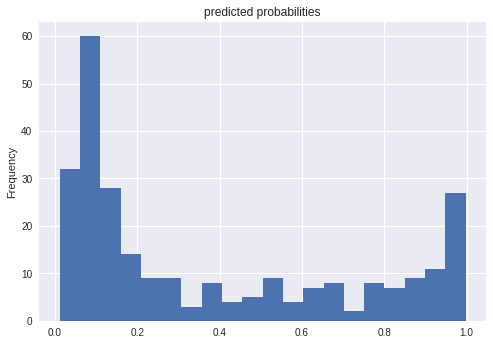

In [42]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

#### Receiver operating characteristic (ROC) curve

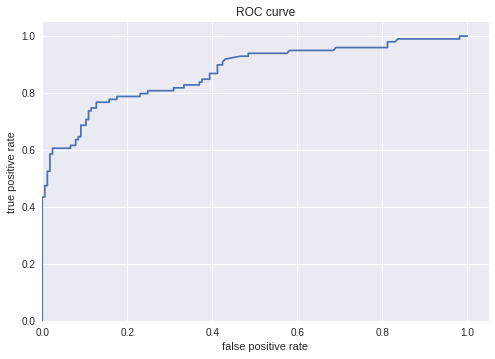

In [43]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);